In [1]:
import jax.numpy as jnp
from jax import Array, random, vmap
from flax import nnx
import optax
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm

In [2]:
class Flow(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs, dim: int = 2, h: int = 64) -> None:
        self.net = nnx.Sequential(
            nnx.Linear(in_features=dim+1, out_features=h, rngs=rngs), nnx.elu,
            nnx.Linear(in_features=h, out_features=h, rngs=rngs), nnx.elu,
            nnx.Linear(in_features=h, out_features=dim, rngs=rngs)
        )

    def __call__(self, x_t: Array, t: Array) -> Array:
        return self.net(jnp.concatenate((t, x_t), axis=-1))

    def step(self, x_t: Array, t_start: Array, t_end: Array) -> Array:
        t_start = jnp.broadcast_to(t_start, (x_t.shape[0], 1))
        return x_t + (t_end - t_start) * self(x_t + self(x_t, t_start) * (t_end - t_start) / 2,
                                              t_start + (t_end - t_start) / 2)

In [3]:
flow = Flow(rngs=nnx.Rngs(0))
nnx.display(flow)

Flow(
  net=Sequential(
    layers=[Linear(
      kernel=Param(
        value=Array(shape=(3, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64,), dtype=float32)
      ),
      in_features=3,
      out_features=64,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7ff0710ee200>,
      bias_init=<function zeros at 0x7ff071bda840>,
      dot_general=<function dot_general at 0x7ff072378360>
    ), <PjitFunction of <function elu at 0x7ff071abede0>>, Linear(
      kernel=Param(
        value=Array(shape=(64, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64,), dtype=float32)
      ),
      in_features=64,
      out_features=64,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7ff0710ee200>,
      

In [4]:
optimizer = nnx.Optimizer(flow, optax.adam(learning_rate=1e-2))

def mse(dx_t_pred: Array, dx_t: Array) -> Array:
    loss = optax.squared_error(dx_t_pred, dx_t).mean()
    return loss

def loss_fn(model: Flow, x_t: Array, t: Array, dx_t: Array) -> Array:
    dx_t_ = model(x_t, t)
    loss = mse(dx_t_, dx_t)
    return loss

loss_grad_fn = nnx.value_and_grad(loss_fn)

In [5]:
@nnx.jit
def train(model: Flow, x_t: Array, t: Array, dx_t: Array, optimizer: nnx.Optimizer) -> Array:
    loss, grads = loss_grad_fn(model, x_t, t, dx_t)
    optimizer.update(grads)
    return loss

In [6]:
num_iterations = 10_000
key = random.key(0)
keys = random.split(key, 2*num_iterations+1)
loss_history = []
for i in tqdm(range(num_iterations)):
    x_1 = jnp.array(make_moons(256, noise=0.05)[0])
    x_0 = random.normal(keys[2*i], shape=x_1.shape)
    t = random.uniform(key=keys[2*i+1], shape=(len(x_1), 1))
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0
    loss = train(flow, x_t, t, dx_t, optimizer)
    loss_history.append(loss)
    key = keys[2]

100%|█████████████████| 10000/10000 [00:49<00:00, 201.36it/s]


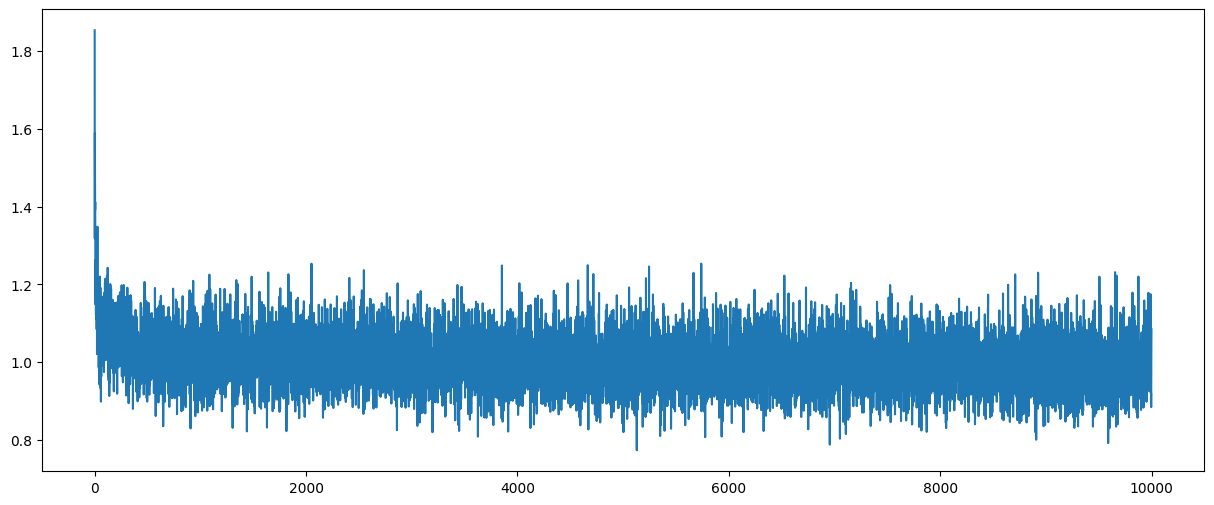

In [7]:
plt.figure(figsize=(15, 6))
plt.plot(loss_history)
plt.show();

In [8]:
x = random.normal(keys[-1], shape=(300, 2))
n_steps = 8

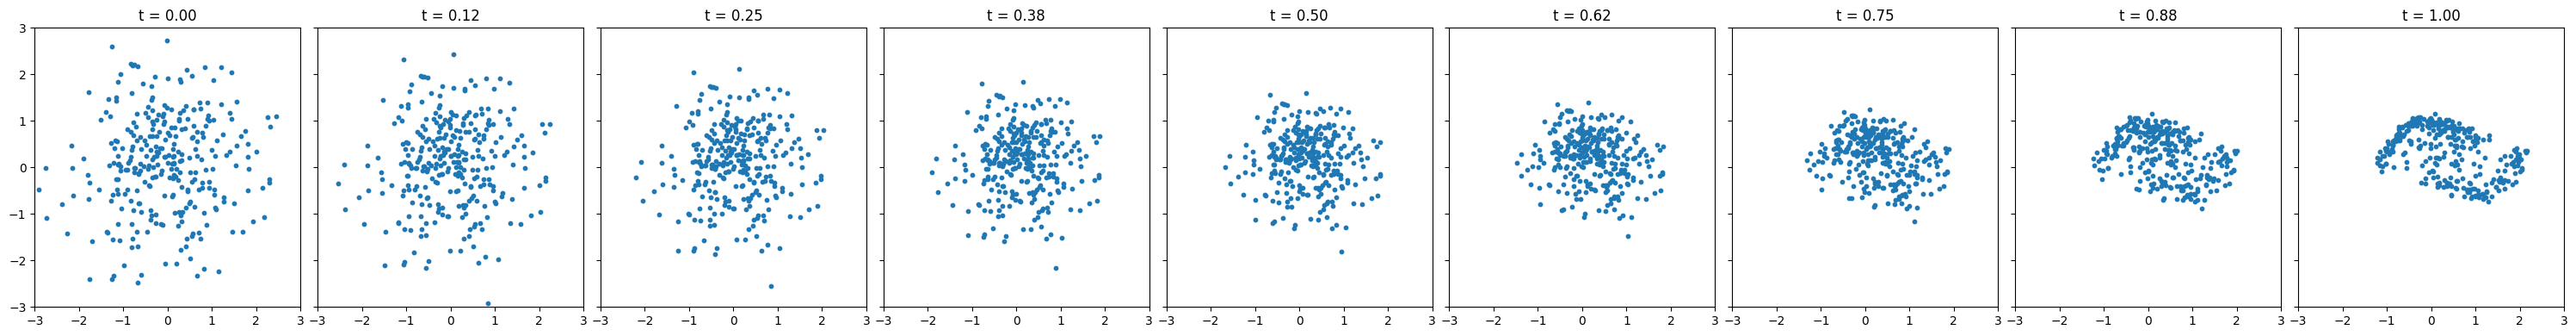

In [9]:
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = jnp.linspace(0, 1., n_steps+1)

axes[0].scatter(x[:, 0], x[:, 1], s=10)
axes[0].set_title(f"t = {time_steps[0]:.2f}")
axes[0].set_xlim(-3., 3.)
axes[0].set_ylim(-3., 3.)

for i in range(n_steps):
    x = flow.step(x, time_steps[i], time_steps[i+1])
    axes[i+1].scatter(x[:, 0], x[:, 1], s=10)
    axes[i+1].set_title(f"t = {time_steps[i+1]:.2f}")

plt.tight_layout()
plt.show()